In [31]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline 

In [32]:
# read in all the words
words = open("names.txt", "r").read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [33]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [52]:
class Linear: 
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out, generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # paramters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffer (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True) # batch mean
            xvar = x.var(dim=0, keepdim=True, unbiased=True)  # batch variance
            # data is a sample from a population so using unbiased (divide by n-1)
            # Using x as sample shrinks variance, so we compensate by dividing by N−1 instead of N.
            # This correction is called Bessel’s correction.
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar - self.eps) # normalise to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [41]:
n_embd = 10 # dimensionality of chars embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP 
block_size = 3
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(block_size * n_embd, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer make less confident 
    layers[-1].weight *= 0.1 
    # all other layers: apply gain 
    for layer in layers[:-1]: 
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # gain by tanh
            # keeping 1 squashes distribution and decreases std from 1 

parameters = [C] + [p for layer in layers for p in layer.parameters()] 
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [42]:
# C        : (vocab_size, n_embd)
# Xb       : (batch_size, block_size)

# C[Xb] → emb : (batch_size, block_size, n_embd)
# Each index in Xb is replaced by its embedding vector.
# [ 0, 1, 5 ]   →   [ vec(.), vec(a), vec(e) ]

# emb.view(emb.shape[0], -1)
# before: emb.shape == (batch_size, block_size, n_embd)
# after: x.shape == (batch_size, block_size * n_embd)

In [43]:
# optimization
max_step = 200000
batch_size = 32 
lossi = []
ud = []

for i in range(max_step):

    # mini-batch construct 
    # torch.randint(low, high, size)
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g )
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,y

    # forward pass 
    emb = C[Xb] # embed chars into vectors 
    x = emb.view(emb.shape[0], -1) # concat vectors 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function 

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain graph 
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01 # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d} / {max_step:7d}: {loss.item():.4f}') 
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i>1000:
        break

      0 /  200000: 3.2962


weight   (27, 10) | mean +0.000772 | std 9.714618e-03 | grad:data ratio 9.714505e-03
weight  (30, 100) | mean -0.000036 | std 8.734046e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424625e-03 | grad:data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.242012e-03 | grad:data ratio 3.681916e-02
weight (100, 100) | mean +0.000007 | std 6.161662e-03 | grad:data ratio 3.650614e-02
weight (100, 100) | mean +0.000069 | std 5.221998e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229574e-01


Text(0.5, 1.0, 'weights gradient distribution')

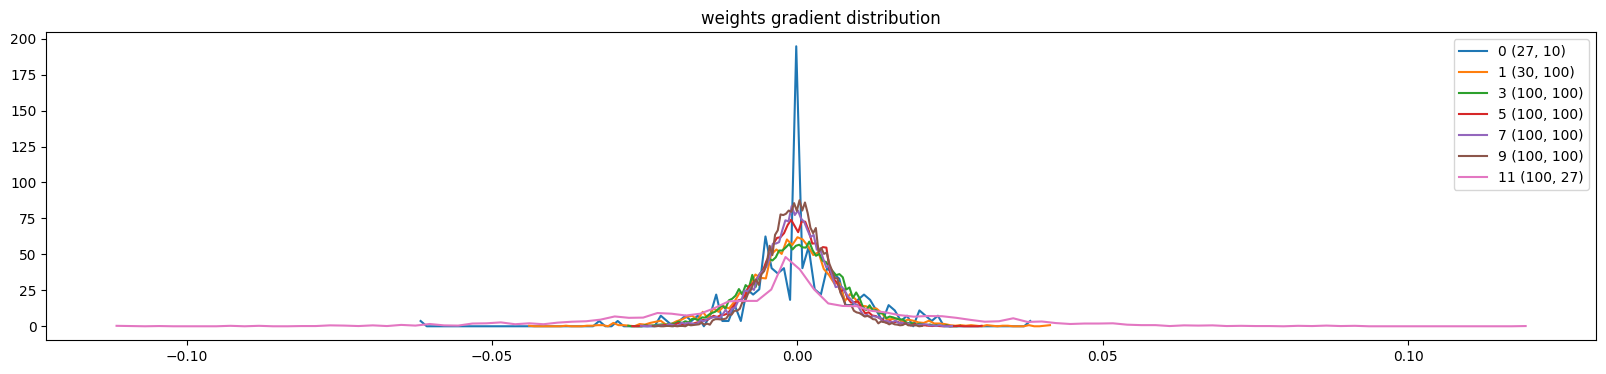

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (
                tuple(p.shape),
                t.mean(),
                t.std(),
                (t.std() / p.std()),
            )
        )

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")

plt.legend(legends)
plt.title("weights gradient distribution")

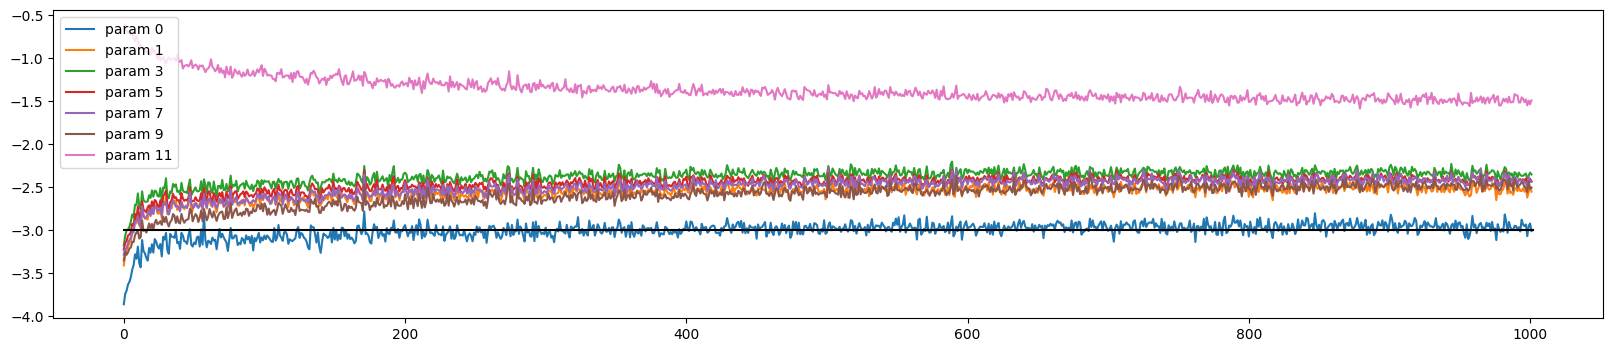

In [47]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")

plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

# lr is low if below line ~1e-3 
# we initialise last layer to be 0.1(equal) hence making it not confident and resulting in big updates in start which is ok

As depth increases, we want both activations and gradients to keep a stable, centered distribution with roughly constant variance.

Not exploding.
Not vanishing.
Not saturating.

### Ideal activation distribution (per layer)

- Mean ≈ 0

- Std ≈ 1

- Symmetric (for tanh / GELU)

- Most mass in the sensitive (non-saturated) region

- Few extreme values

Why? Because:

- Mean drift → bias accumulation

- Large std → saturation / explosion

- Small std → signal collapse

layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


Text(0.5, 1.0, 'activation distribution')

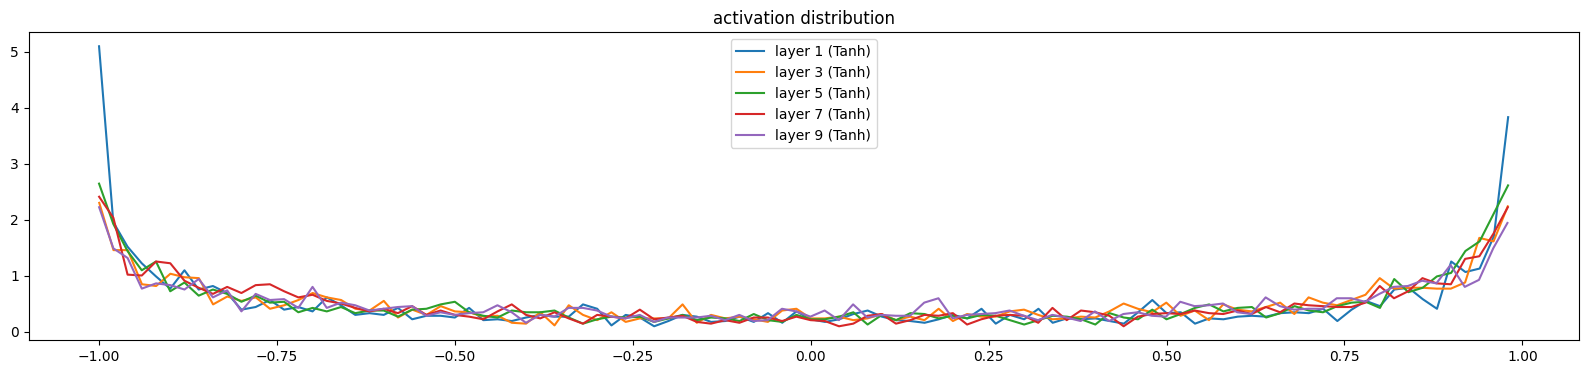

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+ .2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

# When |t| ≈ 1, gradient ≈ 0.
# That neuron is basically dead for learning.

plt.legend(legends)
plt.title("activation distribution")

### Ideal gradient distribution

- Mean ≈ 0

- Std ≈ constant across layers

- No exponential decay

- No exponential growth

If:

Var(J) < 1 → vanishing gradients

Var(J) > 1 → exploding gradients

layer 1 (      Tanh): mean -0.000005, std 3.059083e-03
layer 3 (      Tanh): mean +0.000037, std 3.085331e-03
layer 5 (      Tanh): mean -0.000007, std 2.888204e-03
layer 7 (      Tanh): mean +0.000012, std 2.756315e-03
layer 9 (      Tanh): mean +0.000007, std 2.337389e-03


Text(0.5, 1.0, 'activation distribution')

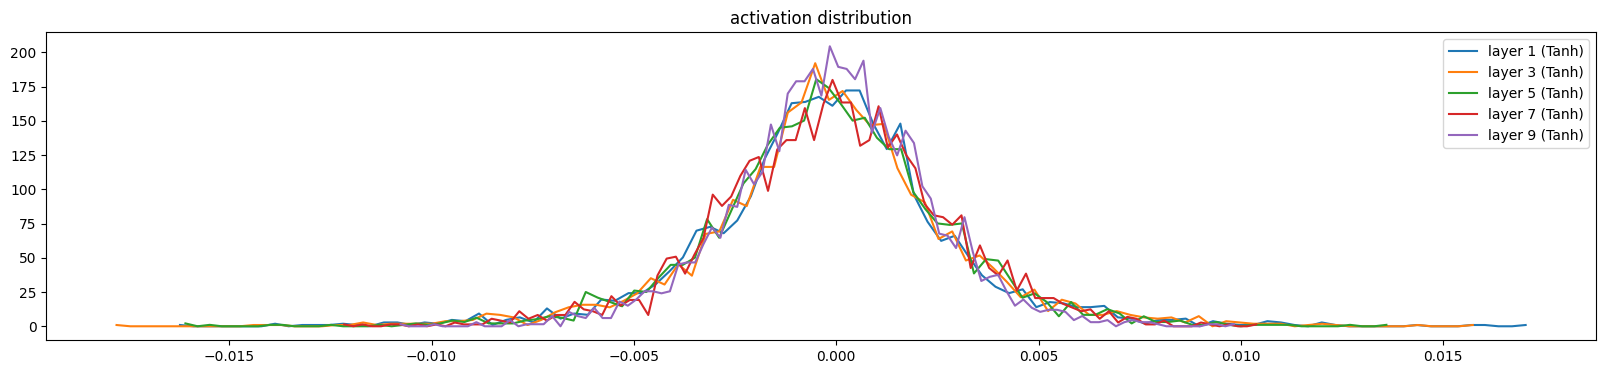

In [46]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
            )
        )

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

# When |t| ≈ 1, gradient ≈ 0.
# That neuron is basically dead for learning.

plt.legend(legends)
plt.title("activation distribution")

### core principle

Forward pass: preserve variance
Backward pass: preserve variance

### For activations

- Mean ≈ 0

- Std ≈ 1

- Avoid saturation

### For gradients

- Variance preserved across layers

- No exponential decay or growth


As depth increases, we want activations and gradients to remain zero-centered with roughly constant variance so information neither dies nor explodes.


# lets do batchnorm to see results

In [53]:
n_embd = 10  # dimensionality of chars embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
block_size = 3
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(block_size * n_embd, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # is the multiplier of output of that layer
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3  # gain by tanh
            # keeping 1 squashes distribution and decreases std from 1
            # GAIN IS STILL IMP FOR LR UPDATES
            # WE CAN REMOVE FAN_IN NORMALISATION IN LEARN TOO BECAUSE OF BATCH NORM.

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [54]:
# optimization
max_step = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_step):

    # mini-batch construct
    # torch.randint(low, high, size)
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,y

    # forward pass
    emb = C[Xb]  # embed chars into vectors
    x = emb.view(emb.shape[0], -1)  # concat vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER DEBUG: would take out retain graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d} / {max_step:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]
        )

    if i > 1000:
        break

      0 /  200000: 3.2870


# Diagnostic plots (important)

weight   (27, 10) | mean +0.000000 | std 8.198671e-03 | grad:data ratio 8.190311e-03
weight  (30, 100) | mean -0.000195 | std 7.650435e-03 | grad:data ratio 2.447710e-02
weight (100, 100) | mean -0.000097 | std 6.207593e-03 | grad:data ratio 3.712888e-02
weight (100, 100) | mean +0.000015 | std 5.561956e-03 | grad:data ratio 3.297650e-02
weight (100, 100) | mean +0.000008 | std 5.220644e-03 | grad:data ratio 3.110177e-02
weight (100, 100) | mean +0.000029 | std 4.829196e-03 | grad:data ratio 2.876389e-02
weight  (100, 27) | mean -0.000014 | std 9.281258e-03 | grad:data ratio 5.568846e-02


Text(0.5, 1.0, 'weights gradient distribution')

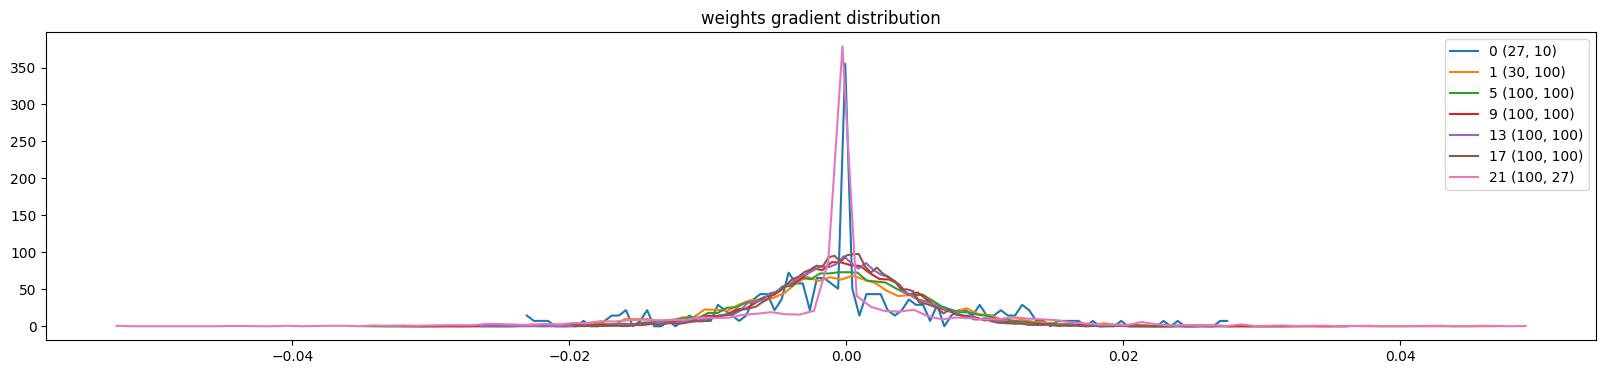

In [55]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (
                tuple(p.shape),
                t.mean(),
                t.std(),
                (t.std() / p.std()),
            )
        )

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")

plt.legend(legends)
plt.title("weights gradient distribution")

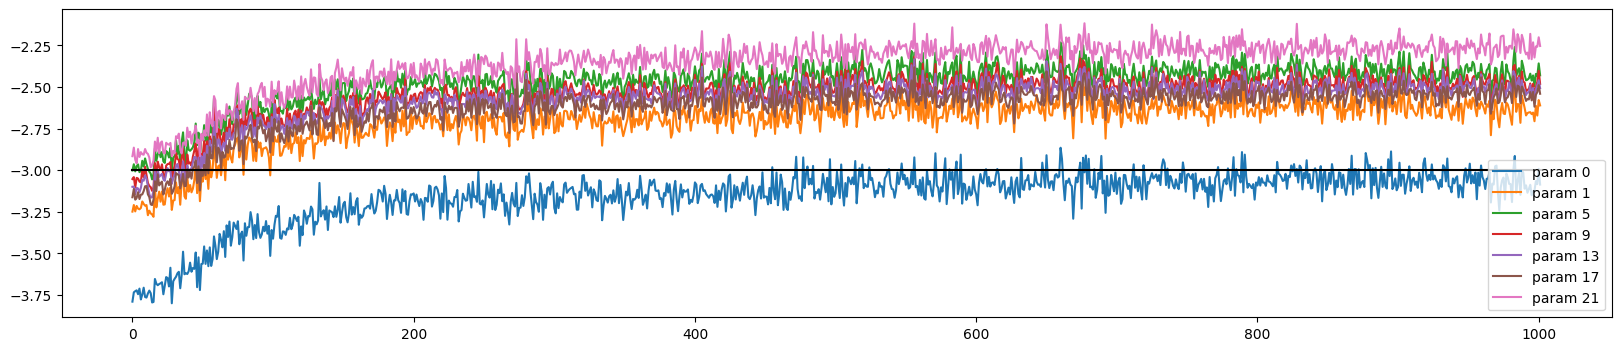

In [56]:
# THE UPDATE IS STILL IMPORTANT ALL ELSE ARE FIXED BY BATCH NORM 
# WE CAN REFORM FAN_IN NORMALISATION IN LINEAR 
# WE CAN REMOVE LAST LAST LAYER * 0.5 WITH GAMMA UPDATE 
# BUT WE SHOULD MAKE SURE UPDATE IS CLOSE TO ~1e-3  BY JUST CHANGIN LR. 
# EVERYTHING ELSE BATCH NORM CAN HANDLE
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")

plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

# lr is low if below line ~1e-3
# we initialise last layer to be 0.1(equal) hence making it not confident and resulting in big updates in start which is ok

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

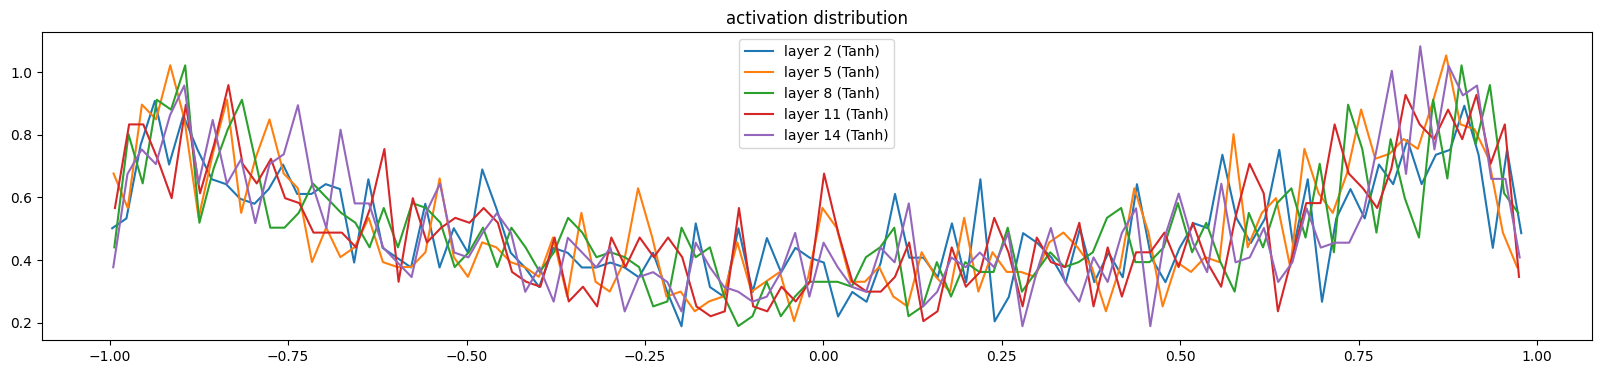

In [57]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+ .2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

# When |t| ≈ 1, gradient ≈ 0.
# That neuron is basically dead for learning.

plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 3.561977e-03
layer 5 (      Tanh): mean -0.000000, std 3.119516e-03
layer 8 (      Tanh): mean +0.000000, std 2.904408e-03
layer 11 (      Tanh): mean -0.000000, std 2.580228e-03
layer 14 (      Tanh): mean -0.000000, std 2.440873e-03


Text(0.5, 1.0, 'activation distribution')

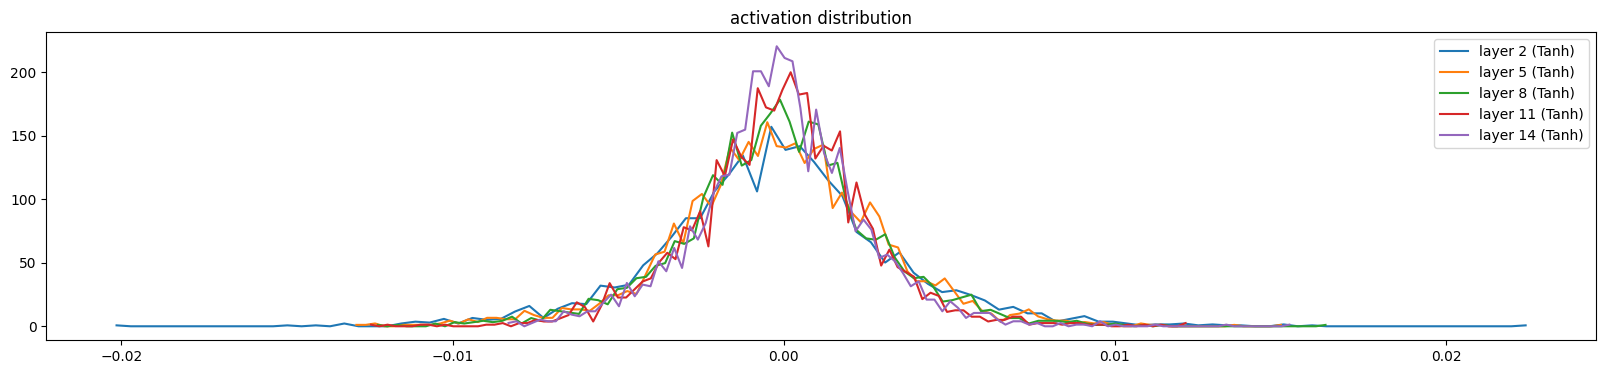

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
            )
        )

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

# When |t| ≈ 1, gradient ≈ 0.
# That neuron is basically dead for learning.

plt.legend(legends)
plt.title("gradient distribution")

E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

- Zero initialization makes neurons identical, and identical neurons stay identical forever.
- All neurons output the same value
- All neurons have the same activation
- All neurons have the same gradient
- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>W</mi><mrow><mi>i</mi><mi>j</mi></mrow></msub></mrow></mfrac><mo>=</mo><msub><mi>x</mi><mi>i</mi></msub><mo>⋅</mo><msub><mi>δ</mi><mi>j</mi></msub></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial W_{ij}} = x_i \cdot \delta_j</annotation></semantics></math>
- All neurons get the same update

What trains

- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>b</mi><mi>j</mi></msub></mrow></mfrac><mo>=</mo><munderover><mo>∑</mo><mrow><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>B</mi></munderover><mrow><mo fence="true">(</mo><msub><mi>p</mi><mrow><mi>i</mi><mo separator="true">,</mo><mi>j</mi></mrow></msub><mo>−</mo><msub><mi>y</mi><mrow><mi>i</mi><mo separator="true">,</mo><mi>j</mi></mrow></msub><mo fence="true">)</mo></mrow></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{
\frac{\partial L}{\partial b_j}
=
\sum_{i=1}^{B}
\left( p_{i,j} - y_{i,j} \right)
}</annotation></semantics></math>
- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mi>b</mi></mrow></mfrac><mo>=</mo><munder><mo>∑</mo><mtext>batch</mtext></munder><mo stretchy="false">(</mo><mtext>softmax</mtext><mo stretchy="false">(</mo><mi>z</mi><mo stretchy="false">)</mo><mo>−</mo><mi>y</mi><mo stretchy="false">)</mo></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{
\frac{\partial L}{\partial b}
=
\sum_{\text{batch}} (\text{softmax}(z) - y)
}</annotation></semantics></math>
- The last layer biases only trains 
- The loss gradient directly flows into the output layer
- Bias gradient does NOT depend on input features
- So output biases can move

What happens to last-layer weights?
- Bias affects logits only:
- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>z</mi><mo>=</mo><mi>h</mi><msub><mi>W</mi><mn>2</mn></msub><mo>+</mo><msub><mi>b</mi><mn>2</mn></msub></mrow><annotation encoding="application/x-tex">z = hW_2 + b_2</annotation></semantics></math>
- But gradient for weights needs input signal: 
- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>z</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>W</mi><mn>2</mn></msub></mrow></mfrac><mo>=</mo><mi>h</mi></mrow><annotation encoding="application/x-tex">\frac{\partial z}{\partial W_2} = h</annotation></semantics></math>
- If h = 0 → gradient = 0 → no learning. 
- last-layer weights do NOT update
- they stay exactly zero forever
- Even if biases update, they do NOT break symmetry in a way that allows last-layer weights or earlier layers to start learning
- Second forward pass (after b₂ changed) 
- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>z</mi><mo>=</mo><mi>h</mi><msub><mi>W</mi><mn>2</mn></msub><mo>+</mo><msub><mi>b</mi><mn>2</mn></msub><mo>=</mo><msub><mi>b</mi><mn>2</mn></msub></mrow><annotation encoding="application/x-tex">z = h W_2 + b_2 = b_2</annotation></semantics></math>
- So predictions shift. 
- But the hidden layer is recomputed first: 
- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>h</mi><mo>=</mo><mi>f</mi><mo stretchy="false">(</mo><msub><mi>W</mi><mn>1</mn></msub><mi>x</mi><mo>+</mo><msub><mi>b</mi><mn>1</mn></msub><mo stretchy="false">)</mo><mo>=</mo><mi>f</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>=</mo><mn>0</mn></mrow><annotation encoding="application/x-tex">h = f(W_1 x + b_1) = f(0) = 0</annotation></semantics></math>
- for weights : 
- <math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>W</mi><mn>2</mn></msub></mrow></mfrac><mo>=</mo><msup><mi>h</mi><mi mathvariant="normal">⊤</mi></msup><mo stretchy="false">(</mo><mi>p</mi><mo>−</mo><mi>y</mi><mo stretchy="false">)</mo><mo>=</mo><mn>0</mn></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial W_2}
=
h^\top (p - y)
=
0</annotation></semantics></math>
- h is still 0, so never updates

| Parameter          | Gradient | Updates? | Why                         |
| ------------------ | -------- | -------- | --------------------------- |
| Hidden weights     | 0        |   No     | symmetry + zero activations |
| Hidden biases      | 0        |   No     | no gradient signal          |
| Last-layer weights | 0        |   No     | depends on (h = 0)          |
| Last-layer bias    | non-zero |   Yes    | independent of inputs       |


E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

# Diagnostics Tools Summary

| **Diagnostic**                                        | **What it Measures**                                  | **Why It’s Important**                         | **What It Should Look Like**                       | **Why You Want to See It**                            |                     |                                         |
| ----------------------------------------------------- | ----------------------------------------------------- | ---------------------------------------------- | -------------------------------------------------- | ----------------------------------------------------- | ------------------- | --------------------------------------- |
| **Weight Gradient Histogram**<br>`p.grad`             | Distribution of gradients for each weight matrix      | Detects vanishing / exploding gradients        | Mean ≈ 0, finite std, similar spread across layers | Ensures gradients flow through depth without collapse |                     |                                         |
| **Grad : Data Ratio**<br>`t.std() / p.std()`          | Relative update size vs parameter scale               | Indicates whether learning rate is appropriate | ~1e-3 (log₁₀ ≈ −3)                                 | Too large → instability; too small → no learning      |                     |                                         |
| **Update Ratio Over Time**<br>`ud` curves             | Stability of parameter updates across training        | Reveals training collapse or divergence        | Flat, stable curves near −3                        | Confirms healthy optimization dynamics                |                     |                                         |
| **Activation Histogram**<br>`layer.out`               | Distribution of neuron outputs                        | Detects saturation and dead neurons            | Mean ≈ 0, std ≈ 1, low mass near ±1                | Prevents vanishing gradients and dead features        |                     |                                         |
| **Activation Saturation** t>97| Fraction of neurons in saturated region            | Quantifies loss of learning capacity                  | Ideally < 5% (tanh) | High saturation ⇒ neurons stop learning |
| **Activation Gradient Histogram**<br>`layer.out.grad` | Distribution of gradients flowing through activations | Detects gradient decay across depth            | Mean ≈ 0, std preserved across layers              | Confirms backprop signal survives depth               |                     |                                         |


Exploding gradients → wide gradient histograms, high grad:data ratio

Vanishing gradients → near-zero histograms, shrinking std layer-by-layer

Bad initialization → early saturation, dead tanh units

Wrong learning rate → noisy or collapsing update-ratio curves

Symmetry issues → identical distributions across neurons/layers